## This is a command to install six Python packages using the pip package manager. The packages are:

- **transformers[sentencepiece]**: A library that provides state-of-the-art natural language processing models and tools, with an optional dependency on SentencePiece, a library for subword tokenization.
- **datasets**: A library that provides easy access to a wide range of datasets and metrics for natural language processing.
- **sacrebleu**: A library that provides hassle-free computation of shareable, comparable, and reproducible BLEU, chrF, and TER scores for machine translation evaluation.
- **rouge_score**: A library that provides Python implementations of ROUGE-L, ROUGE-N, and ROUGE-W for automatic summarization evaluation.
- **py7zr**: A library that provides a pure python module for reading and writing 7z files.

The `-q` option means to give less output during the installation process. This option is useful to reduce the clutter on the screen.

These packages are often used together for tasks such as machine translation and text summarization, where the goal is to generate natural language text from some input. For example, one can use the transformers library to fine-tune a pretrained model, such as MT5, on a machine translation or text summarization dataset, such as XSUM. Then, one can use the datasets library to load and preprocess the data, the sacrebleu and rouge_score libraries to evaluate the model performance, and the py7zr library to compress or decompress the data or model files.


## installing required packages

#### metrixs --> rouge_score, it is used in summerization task

In [ ]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [ ]:
# checking whether GPU is running or not
!nvidia-smi

Sun Jan 21 09:38:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### pipeline --> we need pipeline because , whenever we will be doing inferencing , we need to call pipeline, so inside the pipeline we will be mentioned our task.



In [ ]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# it will check whether i have selected GPU or not, if GPU is selected then, it return "cuda" other wise "cpu"

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

### retrieving our pretrained model from hugging face


In [ ]:
model_ckpt =  "google/pegasus-cnn_dailymail"

### initializing our tokenizer


In [ ]:
# downloading tokenizers of pretrained model by automatically from hugging face
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### downloading our pretrained model from hugging face

In [ ]:
# initialization of our pretrained model
# AutoModelForSeq2SeqLM --> our task is text summerization (given seq and it return seq only), so we use this model
# downloading our pretrained model from hugging face
# which device we should use  during traing time "cpu" or "cuda" --> now it is running on "GPU"

model_pegasum = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### load our data

Link: https://huggingface.co/datasets/samsum

In [ ]:
dataset_samsum = load_dataset("samsum")

In [ ]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
for split in dataset_samsum:
  print(dataset_samsum[split])

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 14732
})
Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 819
})
Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 818
})


In [ ]:
split_len = [len(dataset_samsum[split]) for split in dataset_samsum]
split_len

[14732, 819, 818]

In [ ]:
print(f"Feature: {dataset_samsum['train'].column_names}")

Feature: ['id', 'dialogue', 'summary']


In [ ]:
print("\nDialogue")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary")

print(dataset_samsum["test"][1]["summary"])


Dialogue
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary
Eric and Rob are going to watch a stand-up on youtube.


## we are using pretrained model and checking whether it works good or not. if not, then we do fine tuing

### evaluating PEGASUS on SAMSUM

In [ ]:
dataset_samsum['test'][0]

{'id': '13862856',
 'dialogue': "Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye",
 'summary': "Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."}

In [ ]:
dialogue = dataset_samsum['test'][0]['dialogue']
dialogue

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [ ]:
pipe = pipeline('summarization', model = model_ckpt)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# prediction

pipe_out = pipe(dialogue)
pipe_out

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]

In [ ]:
'''prediction is not well because our "samsum" dataset is not trained, so now we use fine tuning approach with
our own data or custom data.'''

print(pipe_out[0]["summary_text"].replace(' .<n>', '.\n'))

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [ ]:
# here we are not loading entire data to my memory, so i will pass my data by batch_wise

def generate_batch_sized_chunks(list_of_elements, batch_size):
  """split the dataset into smaller batches that we can process simlutaneously yield successive batch_sized
  chunks from list_of_elements"""
  for i in range(0, len(list_of_elements), batch_size):
    yield list_of_elements[i:i+batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [ ]:
rouge_metric = load_metric('rouge')

'''checking an accuracy with pegasum model'''

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasum, tokenizer, column_text = 'dialogue',
                                    column_summary='summary', batch_size=8)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
100%|██████████| 103/103 [18:19<00:00, 10.68s/it]


In [ ]:
# types of rouge metrics
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015548,0.000302,0.015509,0.015511


### Histogram

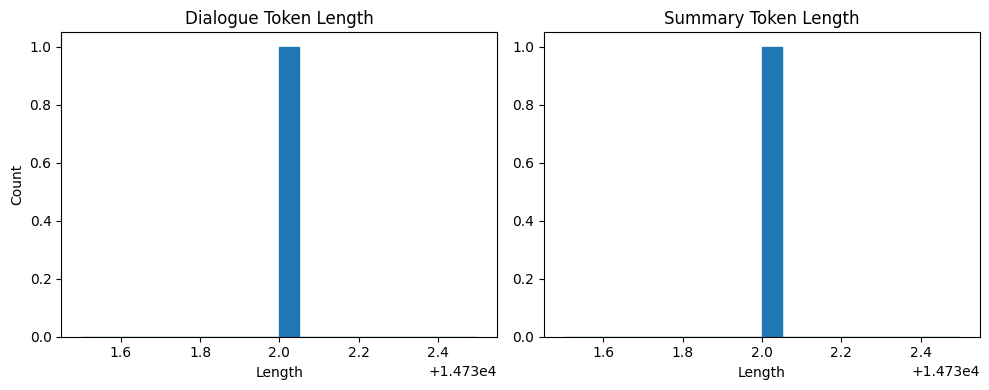

In [ ]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

### converting text to numerical representatinon

In [ ]:
dataset_samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
dataset_samsum_pt['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.',
 'input_ids': [12195,
  151,
  125,
  7091,
  3659,
  107,
  842,
  119,
  245,
  181,
  152,
  10508,
  151,
  7435,
  147,
  12195,
  151,
  125,
  131,
  267,
  650,
  119,
  3469,
  29344,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [12195, 7091, 3659, 111, 138, 650, 10508, 181, 3469, 107, 1]}

### training and validation step

In [ ]:
from transformers import DataCollatorForSeq2Seq

# datacollator means, whenever we define the datacollator, it will take your data as a batches and it will pass it to your model batchwise.
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasum)

In [ ]:
# !pip install accelerate -U

In [ ]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [ ]:
trainer = Trainer(model=model_pegasum, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])


In [ ]:
trainer.train()

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.626500,1.484255


TrainOutput(global_step=920, training_loss=1.8238315105438232, metrics={'train_runtime': 2678.0229, 'train_samples_per_second': 5.501, 'train_steps_per_second': 0.344, 'total_flos': 5526698901602304.0, 'train_loss': 1.8238315105438232, 'epoch': 1.0})

In [ ]:
score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, column_text = 'dialogue',
                                    column_summary='summary', batch_size=2)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'])

100%|██████████| 410/410 [13:04<00:00,  1.91s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018603,0.000328,0.018451,0.018462


In [ ]:
# save our model

model_pegasum.save_pretrained('pegasus-samsum-fmodel')

In [ ]:
# save tokenizer
tokenizer.save_pretrained('tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

## Inferencing using our trained model, retrieving our trained models

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('tokenizer')

In [ ]:
dataset_samsum = load_dataset('samsum')

In [ ]:
sample_text = dataset_samsum['test'][0]['dialogue']

reference = dataset_samsum['test'][0]['summary']

In [ ]:
sample_text

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [ ]:
reference

"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."

In [ ]:
gen_kwargs = {"length_penalty":0.8, "num_beams":8, "max_length":128}

pipe = pipeline("summarization", model='/content/pegasus-samsum-fmodel', tokenizer=tokenizer)

In [ ]:
print('Dialogue')
print(sample_text)

print("\nRference Summary:")
print(reference)

Dialogue
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Rference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [ ]:
# prediction
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])


Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)



Model Summary:
Hannah is looking for Betty's number. Amanda can't find it. Larry called Betty last time they were at the park together. Hannah would rather she text him.


In [ ]:
sample_text = dataset_samsum['test'][4]['dialogue']

reference = dataset_samsum['test'][4]['summary']

In [ ]:
sample_text

'Ollie: Hi , are you in Warsaw\r\nJane: yes, just back! Btw are you free for diner the 19th?\r\nOllie: nope!\r\nJane: and the  18th?\r\nOllie: nope, we have this party and you must be there, remember?\r\nJane: oh right! i lost my calendar..  thanks for reminding me\r\nOllie: we have lunch this week?\r\nJane: with pleasure!\r\nOllie: friday?\r\nJane: ok\r\nJane: what do you mean " we don\'t have any more whisky!" lol..\r\nOllie: what!!!\r\nJane: you just call me and the all thing i heard was that sentence about whisky... what\'s wrong with you?\r\nOllie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol\r\nJane: dont\' worry, we\'ll check on friday.\r\nOllie: don\'t forget to bring some sun with you\r\nJane: I can\'t wait to be in Morocco..\r\nOllie: enjoy and see you friday\r\nJane: sorry Ollie, i\'m very busy, i won\'t have time for lunch  tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!\r\nOllie: 

In [ ]:
reference

"Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."

In [ ]:
print('Dialogue')
print(sample_text)

print("\nRference Summary:")
print(reference)

Dialogue
Ollie: Hi , are you in Warsaw
Jane: yes, just back! Btw are you free for diner the 19th?
Ollie: nope!
Jane: and the  18th?
Ollie: nope, we have this party and you must be there, remember?
Jane: oh right! i lost my calendar..  thanks for reminding me
Ollie: we have lunch this week?
Jane: with pleasure!
Ollie: friday?
Jane: ok
Jane: what do you mean " we don't have any more whisky!" lol..
Ollie: what!!!
Jane: you just call me and the all thing i heard was that sentence about whisky... what's wrong with you?
Ollie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol
Jane: dont' worry, we'll check on friday.
Ollie: don't forget to bring some sun with you
Jane: I can't wait to be in Morocco..
Ollie: enjoy and see you friday
Jane: sorry Ollie, i'm very busy, i won't have time for lunch  tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!
Ollie: ok for tea!
Jane: I'm on my way..
Ollie: tea is ready, di

In [ ]:
# prediction
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])



Model Summary:
Jane is back in Warsaw. She lost her calendar. She's going to meet with Ollie on Friday. She'll bring some sun with her.
